# Машинное обучение, ФЭН ВШЭ

# Практическое задание 3

## Общая информация

Дата выдачи: 29.10.2017

Срок сдачи: 23:59MSK 12.11.2017

### О задании

Практическое задание 5 посвящено использованию ядер в методах машинного обучения. В рамках данного задания вы:
 * исследуете вид разделяющих поверхностей в исходном пространстве в зависимости от типа используемов ядра и значений его параметров
 * используете SVD для сжатия картинок
 * исследуете обычный и ядровый PCA

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW3_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW3_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

## SVM

**1. (0.5 баллов)** Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно разделимыми классами;
- с хорошо разделимыми классами, но не линейно разделимыми;
- с плохо разделимыми классами.

Визуализируйте полученные выборки на плоскости.

Для генерации случайной выборки можно использовать функции из модуля [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

In [1]:
import sklearn 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification
%matplotlib inline

###### Случай с линейно разделимыми классами: 

http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py

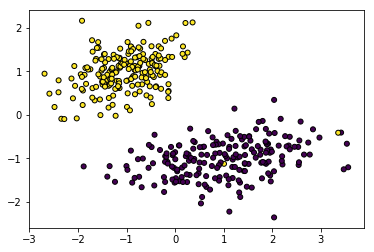

In [2]:
#х1 - двумерный вектор, содержащий объекты, у1 содержит классы данных объектов
x1, y1 = make_classification(n_samples=400, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(x1[:, 0], x1[:, 1], marker='o', c=y1, s=25, edgecolor='k')

###### Случай хорошо разделимых классов (не линейно разделимых):

http://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py

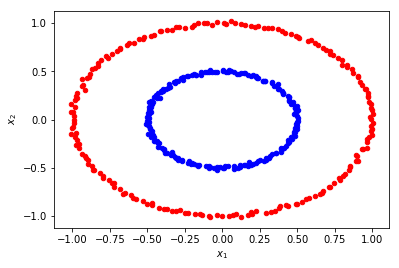

In [3]:
#х2 - двумерный вектор, содержащий объекты, у2 содержит классы данных объектов
x2, y2 = sklearn.datasets.make_circles(n_samples=400, factor = .5, noise=0.01)
reds = y2 == 0
blues = y2 == 1

# Визуализируем выборку: красным выделены объекты класса 0, синим - класса 1
plt.scatter(x2[reds, 0], x2[reds, 1], c="red", s=20)
plt.scatter(x2[blues, 0], x2[blues, 1], c="blue", s=20)   
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

###### Случай плохо разделимых классов:

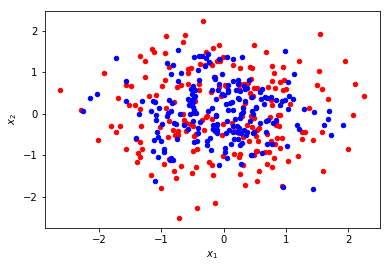

In [4]:
#х3 - двумерный вектор, содержащий объекты, у3 содержит классы данных объектов
x3, y3 = sklearn.datasets.make_circles(n_samples=400, factor = .5, noise=0.6)
reds = y3 == 0
blues = y3 == 1

# Визуализируем выборку: красным выделены объекты класса 0, синим - класса 1
plt.scatter(x3[reds, 0], x3[reds, 1], c="red", s=20)
plt.scatter(x3[blues, 0], x3[blues, 1], c="blue", s=20)   
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Рассмотрим(https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture13-features.pdf) двойственную задачу метода опорных векторов:
$$\begin{cases}
\sum_{i=1}^l \lambda_i - \frac{1}{2} \sum_{i, \, j =1}^l \lambda_i \lambda_j y_i y_j \langle x_i, x_j\rangle \to \max_\lambda,\\
0 \le \lambda_i \le C, i = \overline{1, l},\\
\sum_{i=1}^l \lambda_i y_i = 0.
\end{cases}$$

После решения данной задачи прогнозы для новых объектов строятся следующим образом: $a(x) = \text{sign} \left( \sum_{i=1}^l \lambda_i y_i \langle x_i, x \rangle + b \right).$

Заметим, что и оптимизационная задача, и формула итогового классификатора зависят лишь от скалярных произведений объектов, а потому в данном методе можно использовать ядра для восстановления нелинейных зависимостей.

**2. (1.5 балла)** Обучите на сгенерированных ранее двумерных выборках [ядровой SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) с использованием следующих типов ядер (для различных значений гиперпараметра $C$):
- линейное: $K(x, z) = \langle x, z \rangle$;
- полиномиальное: $K(x, z) = (\gamma \langle x, z \rangle + 1)^d$ (для различных значений $\gamma, d$);
- гауссовское: $K(x, z) = \exp(-\gamma \|x - z\|^2)$ (для различных значений $\gamma$).

Визуализируйте разделяющую поверхность и разделяющую полосу:
 - для модели с линейным ядром для различных значений $C$;
 - для моделей, использующих полиномиальное и гауссовское ядро, соответствующих недообучению, нормальному поведению и переобучению.

In [5]:
import sklearn.svm as svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

http://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py

In [6]:
def try_svm(X, y, ker, gamma=1, d=1, C=1,title=""):
    clf = SVC(kernel=ker,gamma=gamma,degree=d,C=C)
    clf.fit(X, y)
    
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)
    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
    plt.title(title)

###### Случай с линейно разделимыми классами: 

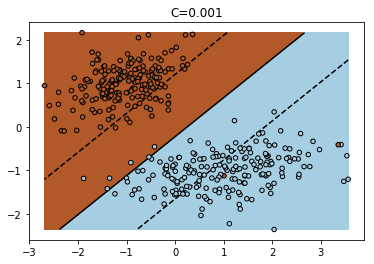

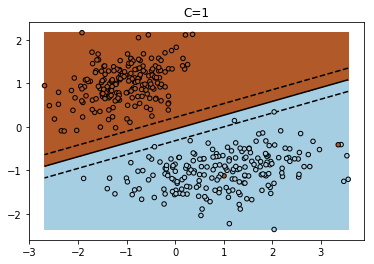

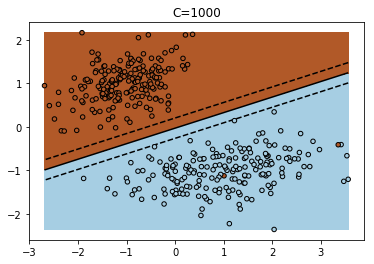

In [7]:
try_svm(x1, y1, 'linear',C=0.001,title="C=0.001")
try_svm(x1, y1, 'linear',C=1,title="C=1")
try_svm(x1, y1, 'linear',C=1000,title="C=1000")

###### Случай хорошо разделимых классов (не линейно разделимых) для полиномиального ядра:

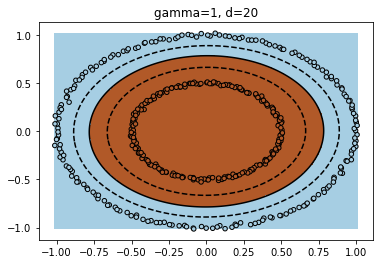

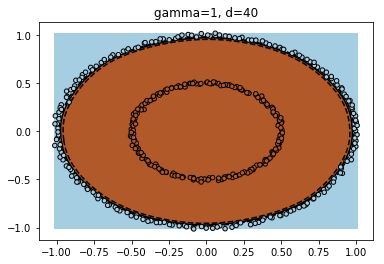

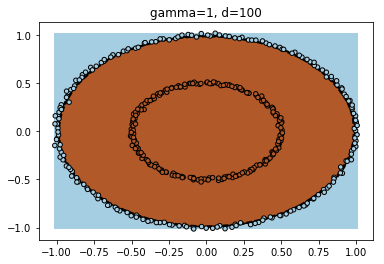

In [8]:
try_svm(x2, y2, 'poly', gamma=1, d=2,title="gamma=1, d=20")
try_svm(x2, y2, 'poly', gamma=1, d=40,title="gamma=1, d=40")
try_svm(x2, y2, 'poly', gamma=1, d=100,title="gamma=1, d=100")

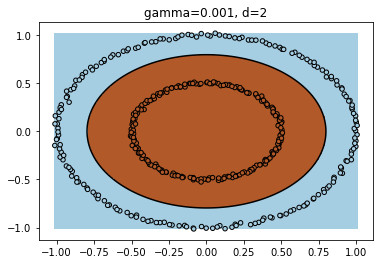

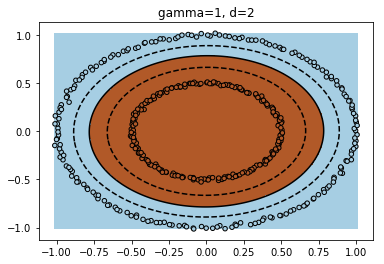

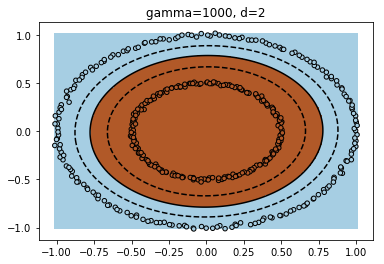

In [9]:
try_svm(x2, y2, 'poly',C=1, gamma=0.001, d=2,title="gamma=0.001, d=2")
try_svm(x2, y2, 'poly',C=1, gamma=1, d=2,title="gamma=1, d=2")
try_svm(x2, y2, 'poly',C=1, gamma=1000, d=2,title="gamma=1000, d=2")

###### Случай плохо разделимых классов для гауссовского ядра:

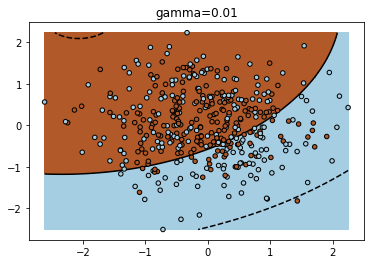

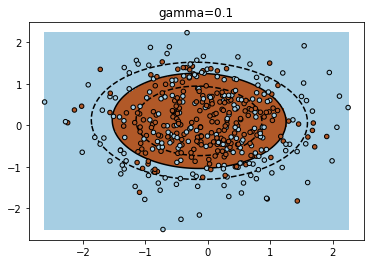

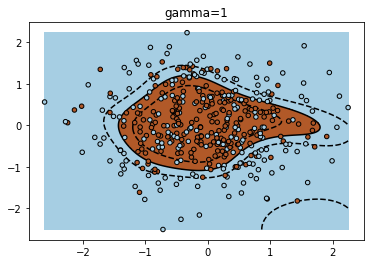

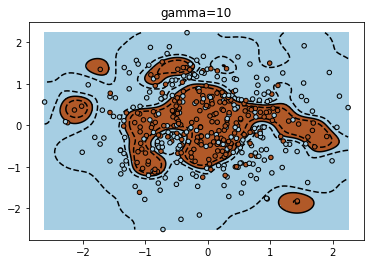

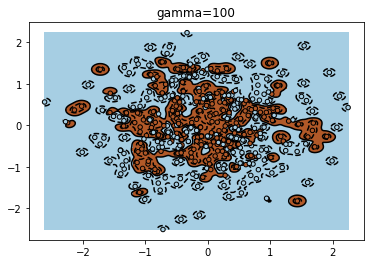

In [10]:
try_svm(x3, y3, 'rbf', gamma=0.01, title="gamma=0.01")
try_svm(x3, y3, 'rbf', gamma=0.1, title="gamma=0.1")
try_svm(x3, y3, 'rbf', gamma=1, title="gamma=1")
try_svm(x3, y3, 'rbf', gamma=10, title="gamma=10")
try_svm(x3, y3, 'rbf', gamma=100, title="gamma=100")

В данном слуае недообучение мы наблюдаем при маленьком значении gamma (0.01), нормальное поведение при значениях 0.1 и 1, а при значениях 10 и 100 происходит переобучение (чем больше гамма, тем сильнее модель переобучилась).

###### Случай плохо разделимых классов для гауссовского и полиномиального ядер при разных С:

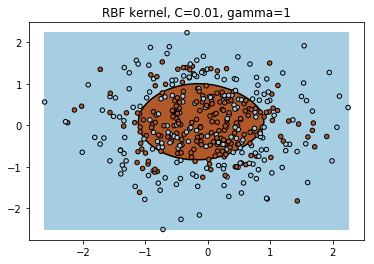

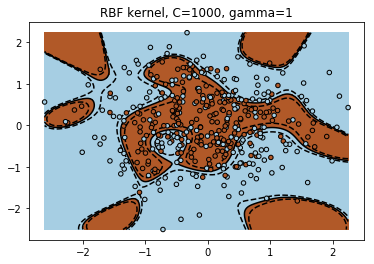

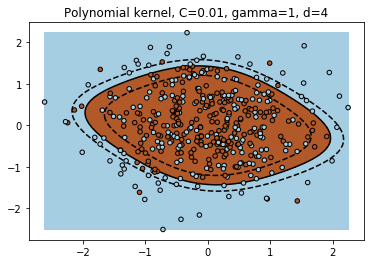

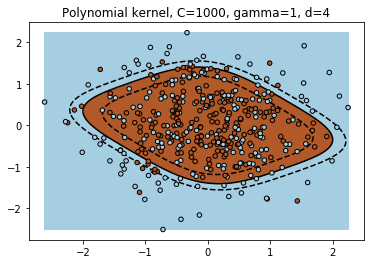

In [11]:
try_svm(x3, y3, 'rbf', gamma=1, C=0.01, title="RBF kernel, C=0.01, gamma=1")
try_svm(x3, y3, 'rbf', gamma=1, C=1000, title="RBF kernel, C=1000, gamma=1")
try_svm(x3, y3, 'poly', gamma=1, C=0.01, d=4,title="Polynomial kernel, C=0.01, gamma=1, d=4")
try_svm(x3, y3, 'poly', gamma=1, C=1000, d=4,title="Polynomial kernel, C=1000, gamma=1, d=4")

**3. (1 балл)** Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от значений гиперпараметра $C$, степени ядра $d$ и параметра $\gamma$?
 - Как ведет себя SVM с гауссовским ядром в зависимости от значений гиперпараметра $C$ и $\gamma$?

**Ответ:** 

1) При $\gamma = 0.001$ и при $\gamma = 1$ ширина разделяющей полосы сильно различается, однако, при $\gamma = 1$ и $\gamma = 1000$ существенных различий не наблюдается. Аналогично, в случае полиномиального ядра увеличение гиперпараметра $d$ ведет к уменьшению разделяющей полосы. С увеличением $d$ уменьшение разделяющей полосы замедляется. С увеличением $С$ коричневый круг, который отмечает объекты второго класса, вытягивается.

2) Как уже было замечено ранее, в случае с гауссовским ядром параметр $\gamma$ сильно влияет на модель (недообучение при маленьких $\gamma$ и переобучение при больших). Что касается гиперпараметра С, то при больших значениях модель также переобучается: на графике появляются новые области, которых не должно быть.

Во всех классификаторах регулируя значение $С$ мы можем менять баланс между количетвом ошибок и шириной раздлительной полосы.

**4. (1.5 балл)** Обучите модели с использованием ядер из п. 2 для задачи бинарной классификации [Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (используйте файл train.csv) для значения $C=1.$ Для оценки качества разбейте выборку на обучающую и тестовую в отношении 50/50. Постройте модель, позволяющую достичь значения accuracy, равного 0.75, на тестовой выборке. Позволяет ли использование ядер достичь лучшего качества по сравнению с линейной моделью?

In [12]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score as accuracy
data = pd.read_csv('biotrain.csv')
data.head()

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Удалим первую колонку, т.к. она содержит ту величину, которую нужно предсказать, и запишем в x_real
# Запишем данные первой колонки в переменные y_real
# Источник - описание данных на Kaggle
y_real, x_real = data['Activity'], data.drop('Activity', axis=1)
# Разделим выборку на тестовую и контрольную:
X_train, X_test, y_train, y_test = train_test_split(x_real, y_real, test_size=0.5)

Точность после обучения на линейном ядре:

In [14]:
svm_lin = SVC(kernel='linear',gamma=1,degree=7,C=1)
svm_lin.fit(X_train, y_train)
accuracy(svm_lin.predict(X_test), y_test)

0.72228144989339016

Точность после обучения на полиномиальном ядре:

In [15]:
svm_poly = SVC(kernel='poly',gamma=1,degree=7,C=1)
svm_poly.fit(X_train, y_train)
accuracy(svm_poly.predict(X_test), y_test)

0.75639658848614078

Точность после обучения на гауссовском ядре:

In [16]:
# Обучим на гауссовском ядре:
svc_rbf = SVC(kernel='rbf',gamma=10,C=1)
svc_rbf.fit(X_train, y_train)

accuracy(svc_rbf.predict(X_test), y_test)

0.55650319829424311

**Ответ:** Наибольшая точность достигнута при использовании полиномиального ядра; оно лучше линейной модели. Самая низкая точность - при использовании гауссовского ядра.

## SVD

Скачайте картинку и положите в каталог рядом с ноутбуком:

In [17]:
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
import sys
%matplotlib inline

img = misc.imread(r'art.jpg')

Посмотрим на нее:

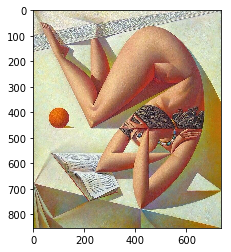

In [18]:
plt.imshow(img);

Для удобства оставим только один канал.

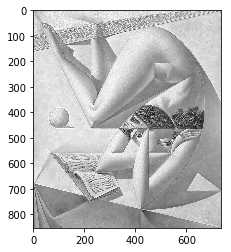

In [19]:
img = img[:,:,0]
plt.imshow(img, cmap='gray');

**5. (1 балла)** 

Главные компоненты - это матрицы вида  $u_i\sigma_iv_i^T$, где  $u_i, v_i$ это столбцы матриц $U$ и $V$ из сингулярного разложения; $\sigma_i$ соответсвующее сингулярное число. Визуализуйте первые и последние несколько компонент. Сделайте выводы.

https://medium.com/@rameshputalapattu/jupyter-python-image-compression-and-svd-an-interactive-exploration-703c953e44f6

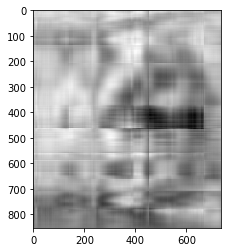

In [20]:
from numpy.linalg import svd
u, s, v = svd(img, full_matrices=False)
comp = 5 #берем первые 5 компонент
plt.imshow(np.dot(u[:,0:comp], np.dot(np.diag(s[0:comp]), v[0:comp,:])), cmap='gray')

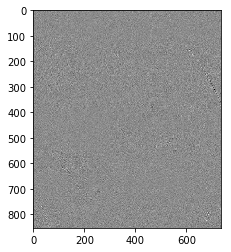

In [21]:
plt.imshow(np.dot(u[:,500:600], np.dot(np.diag(s[500:600]), v[500:600,:])), cmap='gray')

Из последних компонент вообще нельзя что-либо увидеть.

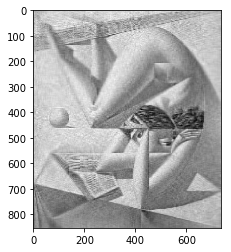

In [22]:
plt.imshow(np.dot(u[:,0:50], np.dot(np.diag(s[0:50]), v[0:50,:])), cmap='gray')

Как можно заметить, в первых компонентах содержится больше информации, чем в последних.

**6. (1 балл)** 

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Используйте график объясненной дисперсии для вашего выбора. Покажите полученные картинки для разного числа компонент.  Во сколько раз меньше памяти потребуется для хранения?  Вес объекта можно узнат командой * sys.getsizeof(x) *


В прошлом номере наиболее адекватный результат дало использование 50 компонент:

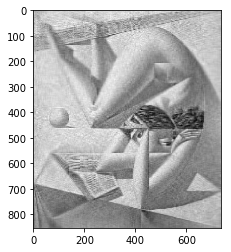

In [23]:
main50 = plt.imshow(np.dot(u[:,0:50], np.dot(np.diag(s[0:50]), v[0:50,:])), cmap='gray')
main50

В данном случае вес объекта:

In [24]:
sys.getsizeof(main50)

56

In [25]:
sys.getsizeof(img)

112

Посмотрим на график объясненной дисперсии:

In [26]:
pca = sklearn.decomposition.PCA()
pca.fit(img)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

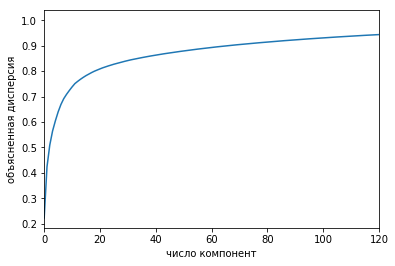

In [32]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim((0, 120))
plt.xlabel('число компонент')
plt.ylabel('объясненная дисперсия')

Случай 20 компонент:

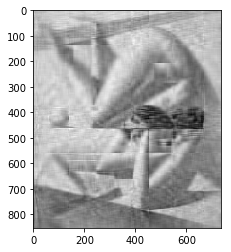

In [28]:
main20 = plt.imshow(np.dot(u[:,0:20], np.dot(np.diag(s[0:20]), v[0:20,:])), cmap='gray')
main20

Вес объекта при 20 компонентах:

In [29]:
sys.getsizeof(main20)

56

Случай 80 компонент:

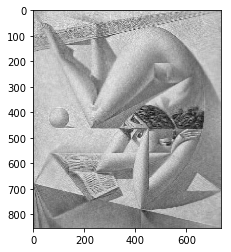

In [30]:
main80 = plt.imshow(np.dot(u[:,0:80], np.dot(np.diag(s[0:80]), v[0:80,:])), cmap='gray')
main80

Вес объекта при 80 компонентах:

In [31]:
sys.getsizeof(main80)

56

https://www.quora.com/What-is-the-best-way-to-choose-the-number-of-components-in-PCA-during-dimensionality-reduction

Насколько я поняла, единственно верного способа выбрать оптимальное количество главных компонент в PCA не существует. Если посмотреть на график объясненной дисперсии, то "на глаз" можем выбрать число в 50 главных компонент. Картинки весят одинаково при разном количестве компонент.

## PCA

Рассмотрим нелиненый датасет. Попробуем решить задачу классификации, используя представление точек, полученнуе с помощью различных версий PCA.

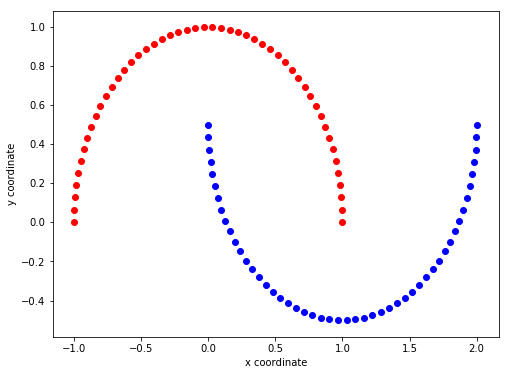

In [33]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=654)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red')
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')


plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

### Linear PCA

**7. (1 балл)** 

Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. 


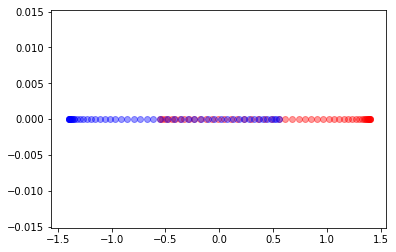

In [34]:
from sklearn.decomposition import PCA
lin_pca = PCA(n_components=1)
X_lin_pca = lin_pca.fit_transform(X)
plt.scatter(X_lin_pca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.4)
plt.scatter(X_lin_pca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.4)

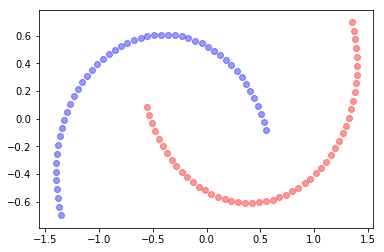

In [35]:
lin_pca_2 = PCA(n_components=2)
X_lin_pca2 = lin_pca_2.fit_transform(X)
plt.scatter(X_lin_pca2[y==0, 0], X_lin_pca2[y==0, 1], color='red', alpha=0.4)
plt.scatter(X_lin_pca2[y==1, 0], X_lin_pca2[y==1, 1], color='blue', alpha=0.4)

### RBF PCA

**8. (0.5 балла)** 
Допишите в месте "Your code here" построение матрицы Грамма для RBF ядра, с параметром gamma. Обратите внимание, что выше в коде уже получена матрица попарных расстояний sq_dists

In [36]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

https://github.com/lucasrodes/kPCA-denoising-python/blob/master/gaussianPCA.py

In [37]:
def stepwise_kpca(X, gamma, n_components):
    """
    X: A MxN dataset as NumPy array where the samples are stored as rows (M), features as columns (N).
    gamma: coefficient for the RBF kernel.
    n_components: number of components to be returned.

    """
    # Calculating the squared Euclidean distances for every pair of points
    # in the MxN dimensional dataset.
    sq_dists = pdist(X, 'sqeuclidean')

    # Converting the pairwise distances into a symmetric MxM matrix.
    mat_sq_dists = squareform(sq_dists)

    K = exp(-gamma * mat_sq_dists) 

    # Centering the symmetric NxN kernel matrix.
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Obtaining eigenvalues in descending order with corresponding
    # eigenvectors from the symmetric matrix.
    eigvals, eigvecs = eigh(K)

    # Obtaining the i eigenvectors that corresponds to the i highest eigenvalues.
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))

    return X_pc

**9. (2 балл)**  
Постройте графики, полученные проекцией на одну и две главные компоненты. Сохраняйте цвет для разных классов. Подберите такой параметр gamma, что выборка стала линейно разделимой.

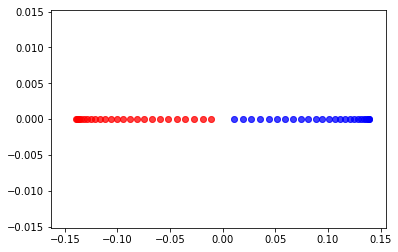

In [38]:
X_spca = stepwise_kpca(X, 100, 1)

plt.scatter(X_spca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)

### Ваши мысли о задании:

Сильно приятнее ДЗ2!

### Здесь можете поделиться картинкой

In [39]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pp.userapi.com/c638916/v638916478/51f6a/x90bo4MnC-Y.jpg")